# Scraping data on readers and books from City Readers
As I noted in the introductory notebook, City Readers does not provide file downloads of their data—it's a resource that's really designed for a user to interact with in their web browser. This notebook walks through scraping data from City Readers to construct a network graph. 

Before getting into the scraping, I want to describe the set of records I wanted to examine in hopes of detecting a network. The aim was to start by identifying the people who borrowed books within a short period (from July 19-23, 1800), then identifying all of the books that those borrowers borrowed throughout 1800 to see which books various July 19-23 borrowers might have had in common.

(It's worth disclosing at the outset that my principle for selection is open to debate. I was trying to keep an eye on ending up with a manageable number of nodes and edges in the network graph, so I limited my borrowers to just those in a single week. Does that actually make sense? Is it an informative sample? Next, I limited the books I looked at to just the ones that they borrowed in 1800. If I'm really interested in what they had in common, should I have looked at *all* the books they borrowed ever? All the books they had borrowed up 'til July 19-23, 1800? As with many of our examples, the notebooks aim at providing a concrete example of techniques in action. In our discussion, though, I hope we'll have time to look beyond the details in the notebooks to ask broader methodological questions.)

As is often the case with web scraping like this, I ended up running into some unexpected wrinkles along the way, so this notebook shows some of the ways you can work around problems in this kind of work. I should emphasize, though, that this notebook doesn't show *systematic* solutions for dealing with unexpected problems in web scraping, but rather illustrates some of the kinds of ad hoc solutions you might employ to deal with problems as they arise.

The code in the cell that does the actual scraping, below, only gets information for five books, and only two of those books were borrowed bwtween July 19 and 23 (by four different patrons). The amount of data that the script will produce as it's configured here, then, is going to be very small. We'll still save it as a /csv file so you can see how that step works. If you want to create a network graph with the City Readers data I scraped, I've provided full .csvs in the `data_class` folder

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

## Getting an initial list of links to scrape
Rather than constructing a query to send to the City Readers database (as we did in fetching geolocation information from the GeoNames server), I started by performing an advanced search at the site to find all borrowing activity between July 19 and July 23, 1800. I then used a Chrome browser extension called [Scraper](https://chrome.google.com/webstore/detail/scraper/mbigbapnjcgaffohmbkdlecaccepngjd), which allows you to extract data from web pages using [XPath](https://developer.mozilla.org/en-US/docs/Web/XPath) into a tabular format that can be pasted into a spreadsheet or imported directly to Google Sheets.

This kind of scraping can be very handy for one-off tasks like this. When I had the results from the advanced search, I used my browser's developer tools to inspect the page structure. (In Google Chrome or other Chromium-based browsers, you can find these tools under `View > Developer > Developer Tools`.) 

The screenshots below show me scraping information about the 125 books that were borrowed between July 19 and 23, 1800. As I note below, however, I eventually had to go back and do this for a much larger set of books.

(I've provided a .csv file of the output from this larger scrape in our `data_class` folder, so you *don't* need to do this step, yourself if you want to create a network graph from the City Readers data.)

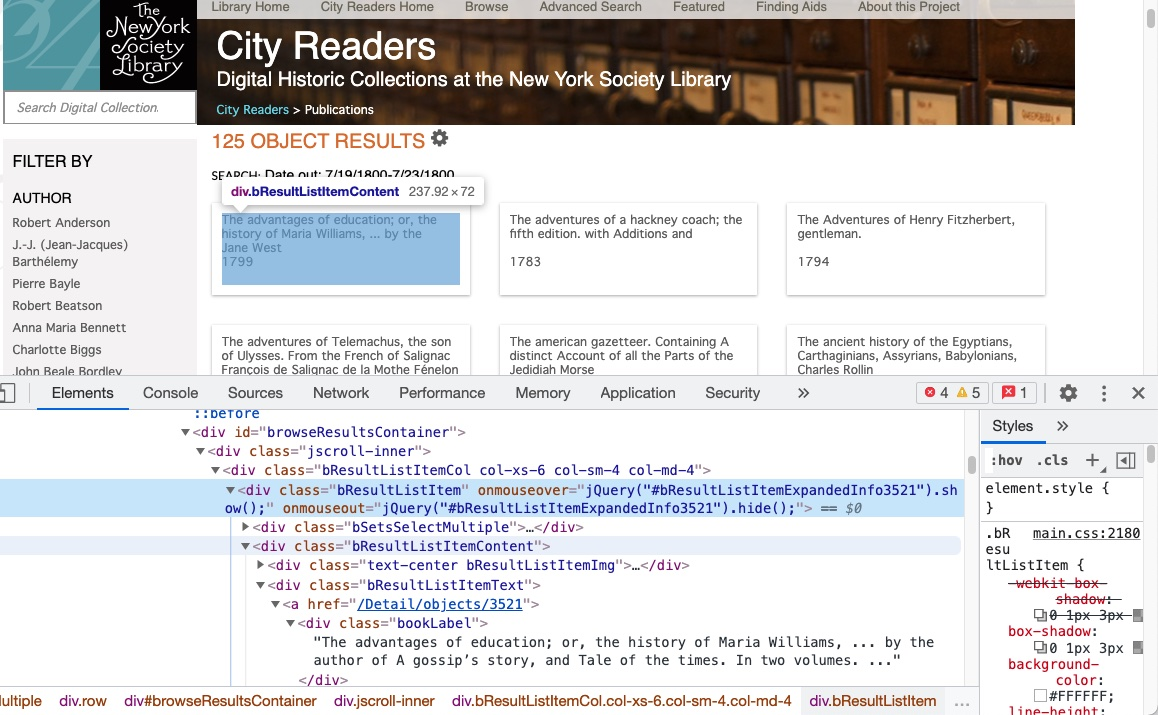

Once I had a basic sense of how the results page was assembled, I right-clicked and used the Scraper extension's "Scrape similar" command to bring up the Scraper window.

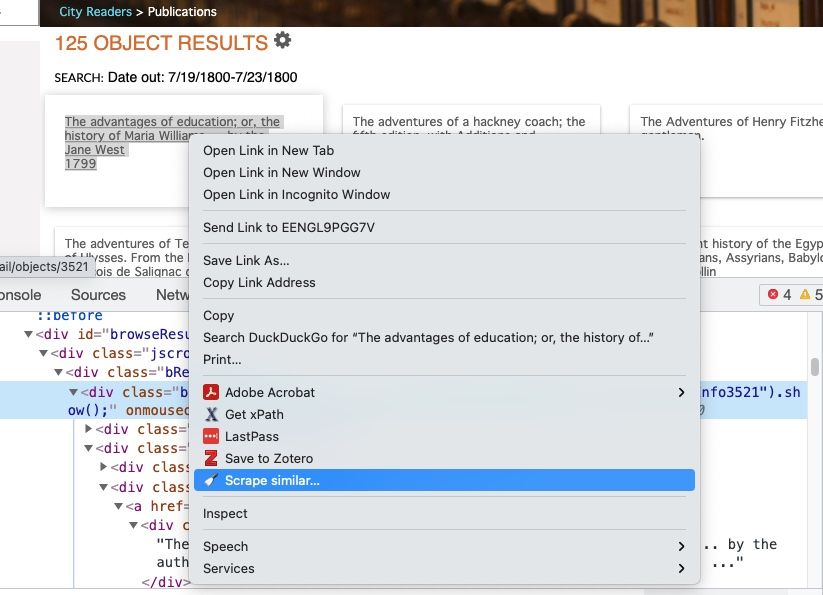

Figuring out exactly what information to extract using Scraper can take a little bit of trial and error (at least it does for me). You need to supply a base element to start from in the field at the top of the Scraper window, then identify the specific elements you want to scrape as columns in your tabular output.

In the screenshot below, my starting element is:

>`//div[@class="bResultListItemCol col-xs-6 col-sm-4 col-md-4"]//div[@class="bResultListItemText"]/a`

The initial double slashes mean that I want the `div` element with the a `class` attribute of `bResultListItemCol col-xs-6 col-sm-4 col-md-4` wherever it appears in the document tree (rather than having to navigate explicitly down to that level). Then at some (unspecified) point below *that*, I want to get all the `div` elements with a `class` attribute of `bResultListItemText`, and retrieve the `a` element (that is the hyperlink).

With that as my starting point, I retrieve two specific pieces of information:

* The text of the `div` element inside the `a` element (using the XPath `text()` command);
* A string that results from concatenating the beginning of a URL that I supply (`''https://cityreaders.nysoclib.org'`) with the contents of the `href` attribute of the `a` element. (I have to supply the first part of the URL because the actual `href` attribute only includes the specific direction to the page in question within the site).

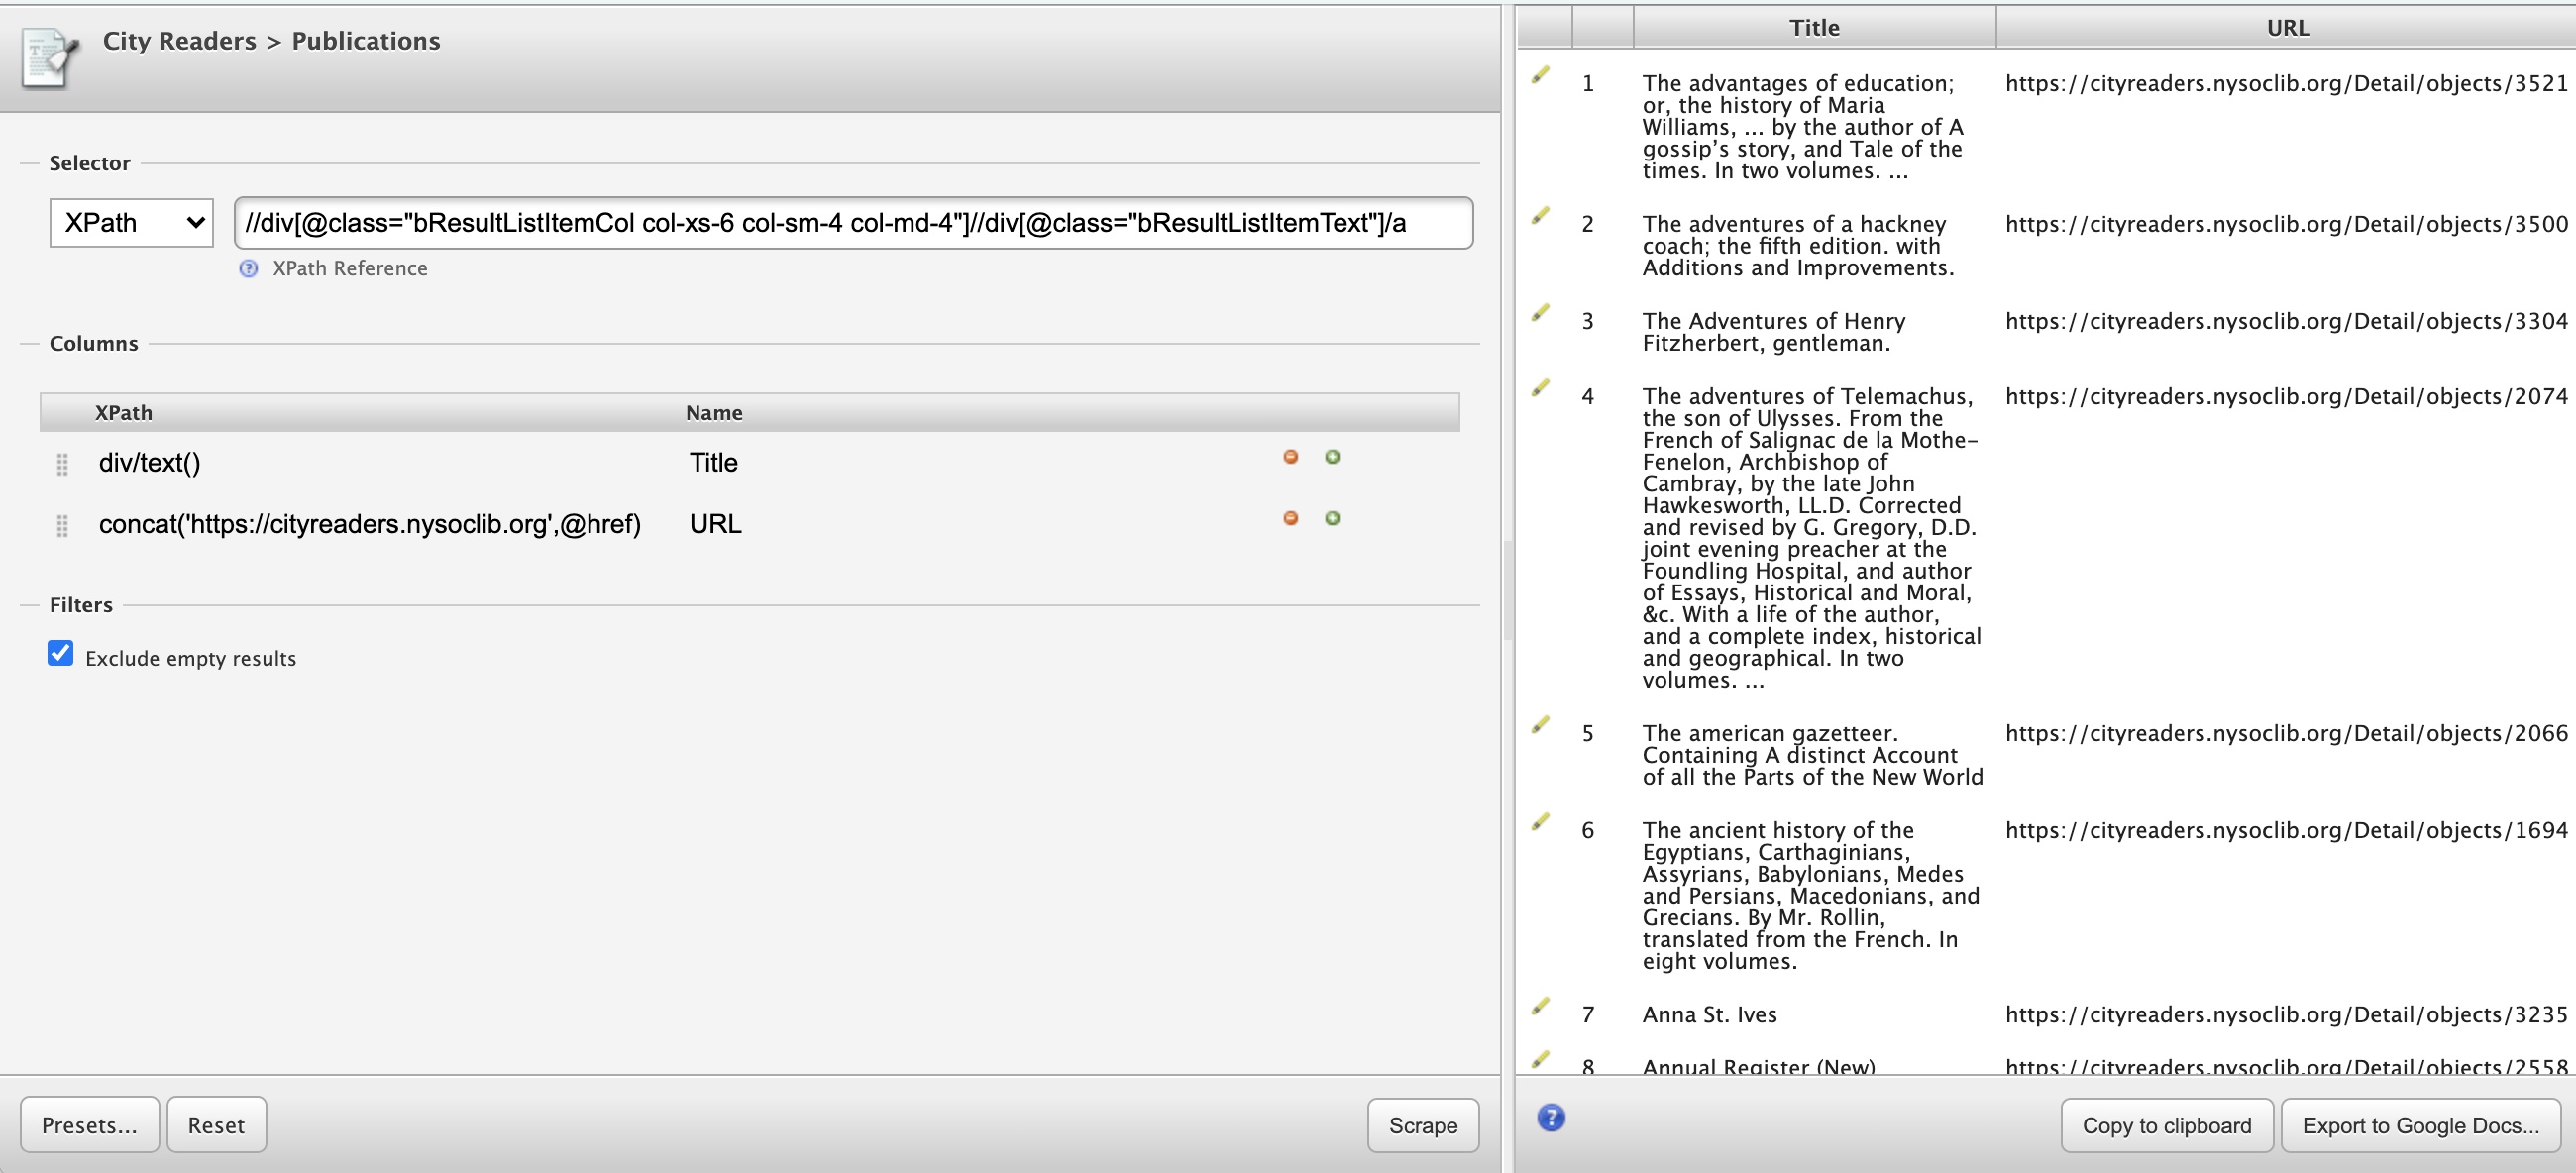

I copied the scraped information to my clipboard, pasted it into a spreadsheet, and exported the spreadsheet as a .csv file (which I've provided in our `data_class` folder). The code below will draw on that .csv file

## The strategy I would use knowing what I know now
My initial strategy for this scraping project was fairly narrowly targeted. It consisted of:
1. Identifying the (ca. 125) books that were borrowed between July 19 and July 23, 1800 through a search at the website and scraping the links to those books using the Scrapr extension for Chrome;
2. Using some Python code to visit the links for each of those books to identify the (ca. 140) people who borrowed those books that week;
3. Using some more Python code to visit the links for each of those people to identify the books that they borrowed throughout 1800.

Thus, this *should* have involved a reasonably small number requests: one for each of the ca. 125 books, and one more for each of the ca. 140 people. 

As it happened, though, there were problems with records for eleven of the borrowers I identified in step 2—requests for those records consistently timed out with a server error, both in my Python code and just visiting in the browser. That meant that I ended up going back to visit the links for all 1,200 or so books checked out in the year 1800 (inevitably including many that the borrowers I had decided to focus on hadn't actually borrowed in 1800) in order to fill in the borrowing habits of the borrowers whose records would not load. 

Since I ended up having to visit the links for all 1,200 of those books, anyway, I could have just started there and gotten all the information I needed in one pass.

## Scraping
**Note:** The code below shows how you *would* scrape these data from City Readers, but only *actually* scrapes a small amount of data. 

### Import necessary packages
We'll use several packages in this script:

* `pandas` for reading our file of intial links to scrape (I'm more familiar with `csv`, but `pandas` provides an easy way of only loading a limited number of rows from a .csv file, which is helpful for this notebook where we don't want to scrape everything.)
* `csv` for writing our data to .csv later (`pandas` could do that, too, but, as I say, I'm more familiar with `csv`)
* `requests` for retrieving the information from City Readers and `BeautifulSoup` for parsing it
* `numpy` and `time` for creating a variable pause between requests
* `json` for storing and writing our information as JSON

In [ ]:
import pandas as pd
import csv
import json
import requests
import re
from bs4 import BeautifulSoup
import numpy as np
import time

### Defining functions for reuse
I've written three functions for this scrape.

#### 1) Pausing between requests
The `backoff` function first creates a random integer and then generates a random exponential value for it. If the result ends up being less than 3, it multiples the result by 2 and adds 3 to it.

**Full disclosure:** I am pretty confident that there is a better way to implement this that would still get good results. The general idea is that it's important to pause between requests to a server, in part to avoid overwhelming the server, but also to avoid problems caused by intermittent glitches. Having the pauses between requests be of varied length is helpful, as best I understand, because a failed request that's repeatedly retried at a determinate interval can end up just causing a kind of "ripple" effect that will keep on failing. There is probably a Python package out there that will solve precisely this problem better than I have done. Indeed, a preliminary glance suggests that [`backoff`](https://pypi.org/project/backoff/) might do the trick.

In [22]:
#Random exponential backoff
def backoff() :
  rng = np.random.default_rng(1234)
  #I performed this scrape with larger numbers for low and high, which led 
  #to sometimes dramatically longer pauses between requests than you'll see
  rint = rng.integers(low=2, high=5, size=1)
  backoff = np.random.exponential(rint[0])
  if backoff < 3 :
    backoff = 3 + backoff*2
  return backoff

#### 2) Get subject and borrowing information from books
The main work of scraping happens in this function. I've provided comments in the code to explain what's happening, but the screenshot below shows the parts of the page that this code is examining.

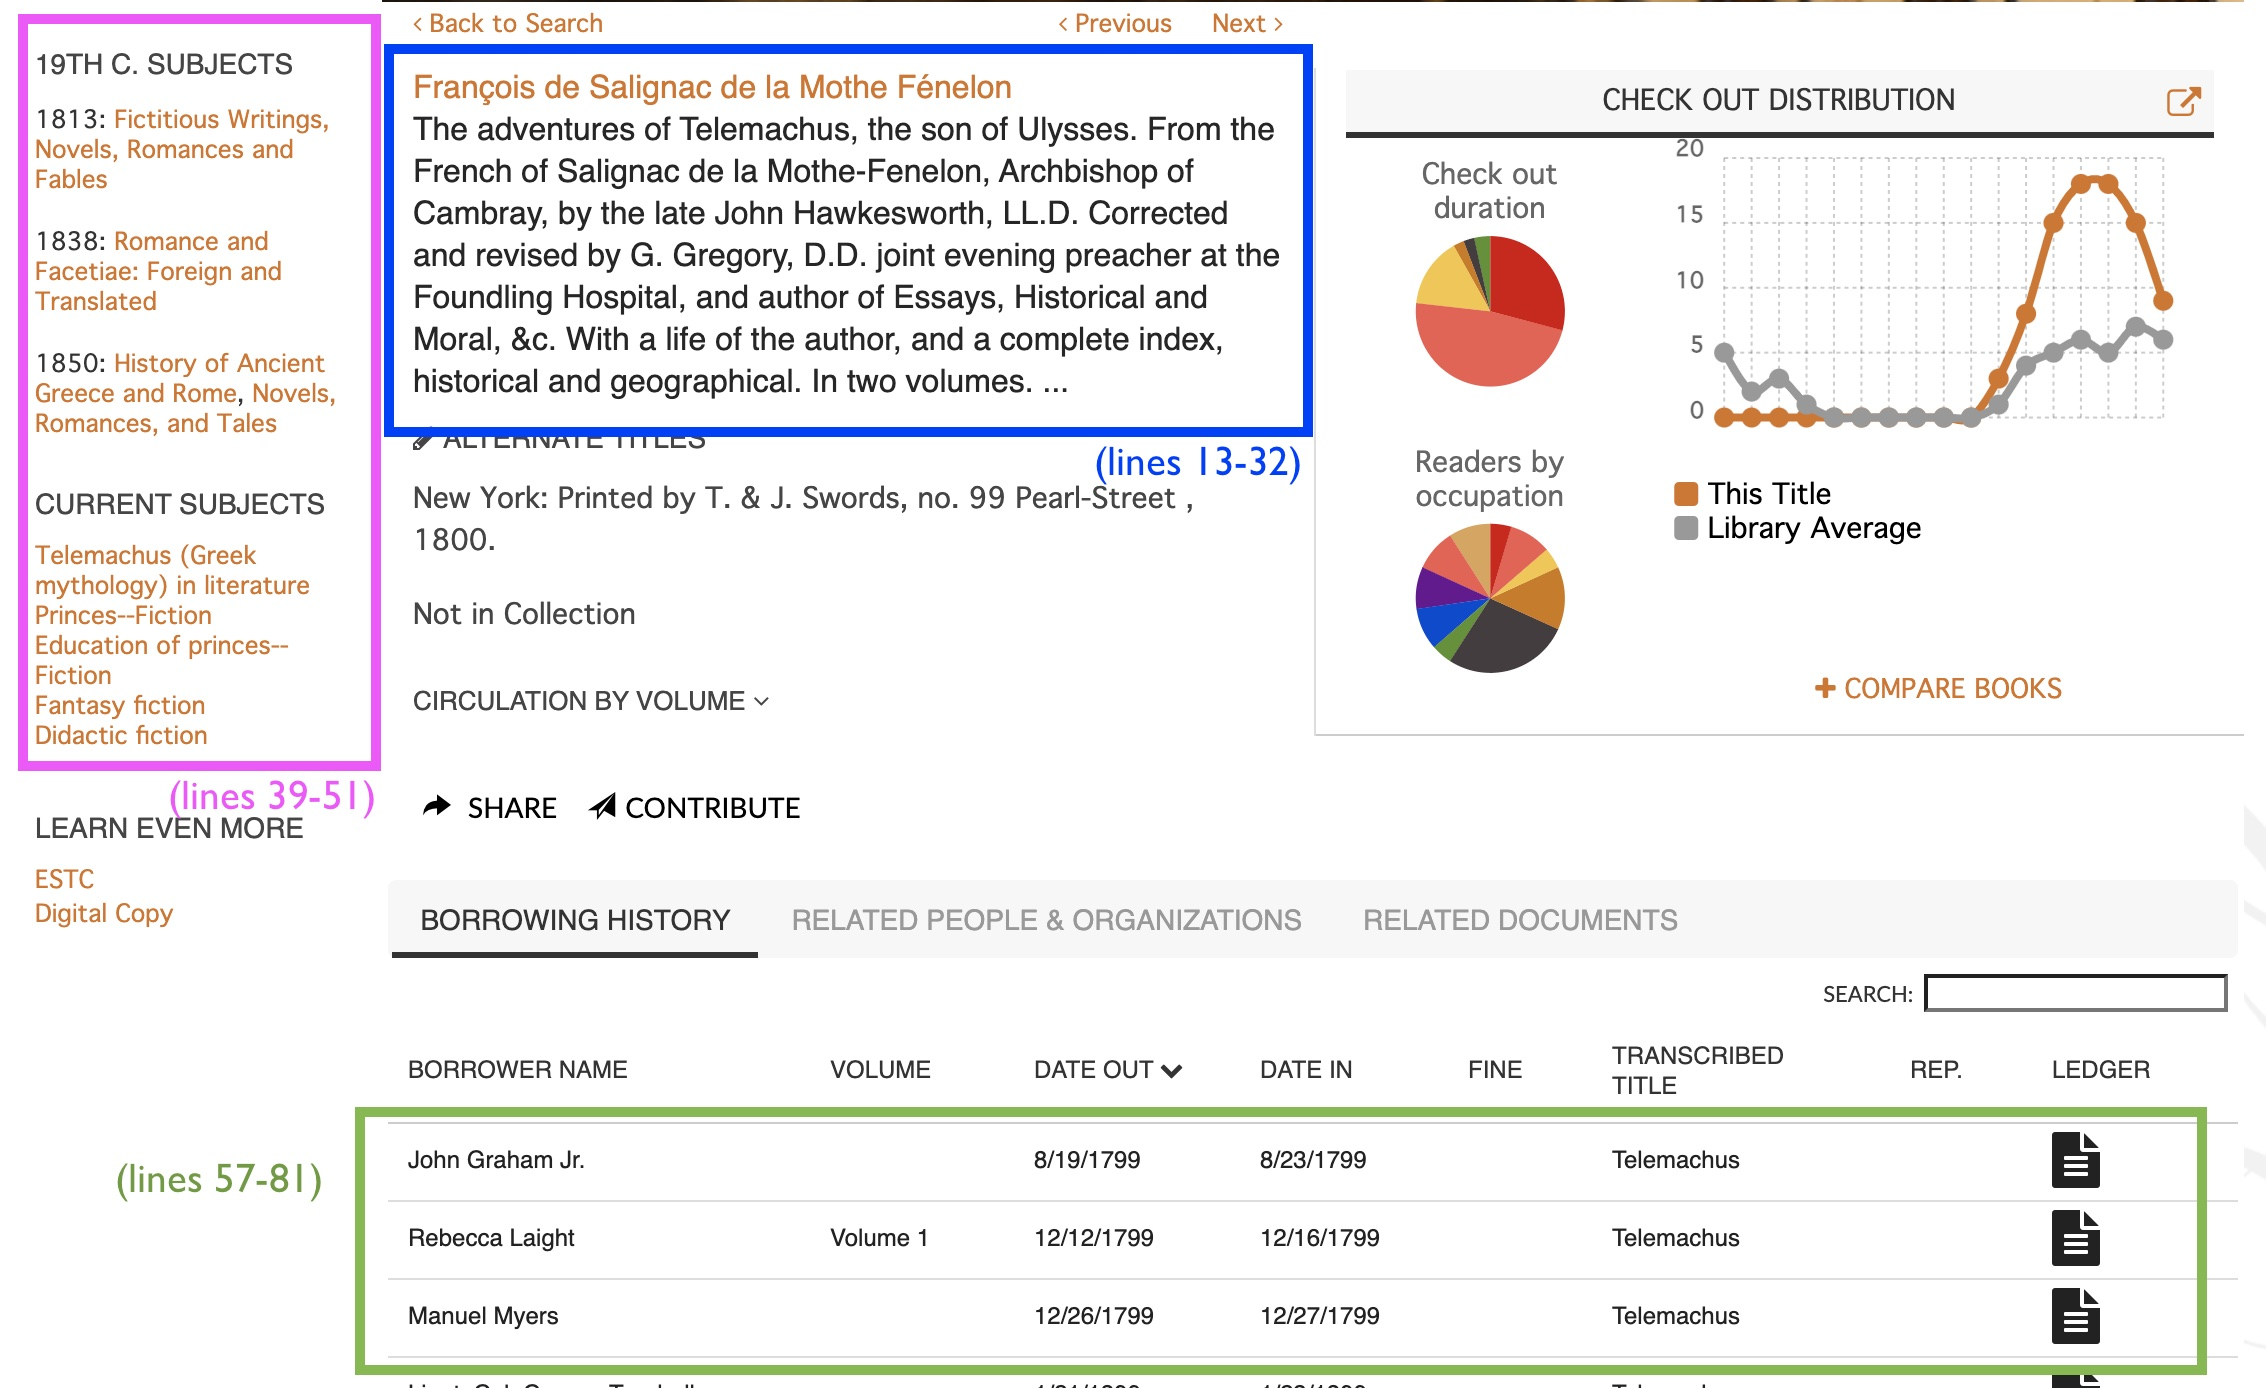

In [12]:
#Function to get book title, current subjects, and borrowing history
#Expects a URL for a book at NY Society Library's City Readers site
def book_info(cr_url) :
  
  #Get the URL with requests and pass the content to BeautifulSoup
  r = requests.get(cr_url)
  soup = BeautifulSoup(r.content)
  
  ###################################################
  ## Get book author (if one is present) and title ##
  ###################################################
  
  #Identify div with author and title
  column = soup.find('div', class_='col-sm-6 col-md-6 col-lg-6')
  
  #Get all h4 elements in that div
  h_fours = column.find_all('h4')
  
  #If the first h4 contains a hyperlink with the word "entities" in
  #its href attribute, an auhor is present
  if h_fours[0].find('a', href=re.compile('entities')) is not None :
    #Use the text of the first h4 for the author and the text of the 
    #second h4 as the title
    author = h_fours[0].find_all('a')[1].get_text()
    title = h_fours[1].get_text()
  
  #If the first h4 doesn't have a hyperlink with "entities" in the 
  #href attribute, no author is present. Set author to blank and use
  #text of the first h4 as title
  else :
    author = ''
    title = h_fours[0].get_text()
  
  ####################################################
  ## Get the current subject heading for the book,  ##
  ## if one is available.                           ##
  ####################################################
    
  #Set subject to blank in case no current subject heading is present
  subject = ''
  #If there is a div with class "sidebar"...
  if soup.find('div', class_='sidebar') is not None :
    sidebar = soup.find('div', class_='sidebar')
    #If there are any h6 elements in the sidebar, get them  
    if sidebar.find_all('h6') is not None :
      sidebar_headings = sidebar.find_all('h6')
      #If one of the sidebar headings reads "Current Subjects"...  
      for sidebar_heading in sidebar_headings :
        if sidebar_heading.get_text() == 'Current Subjects' :
          #Only gets first subject heading. Could be modified to get all.
          subject += sidebar_heading.next_sibling.get_text()
  
  ####################################################
  ## Get the borrowing information for the book:    ##
  ####################################################
    
  #Get all tr elements with the class attribute "ledgerRow"
  ledger_rows = soup.find_all('tr', class_='ledgerRow')
  
  #Create an empty list to hold information from the ledger_rows: this will end
  #up being a list of lists
  output_rows = []
  
  #Iterate through the ledger_rows
  for ledger_row in ledger_rows :
    #Get all td elements for the row
    cells = ledger_row.find_all('td')
    
    #Get the hyperlink and text of the contents of the first cell (the borrower's
    #name)
    link = 'https://cityreaders.nysoclib.org' + cells[0].a['href']
    label = cells[0].a.get_text()
    
    #Get the text of the second column (the borrower's occupation)
    second_col = cells[1].get_text()
    
    #Get the text of the third column (the checkout date)
    checkout = cells[2].get_text()
    
    #Append the above values as a list to the output_rows list
    output_rows.append([link, label, second_col, checkout])

  ####################################################
  ## Construct a dictionary to return as the result ##
  ## of the function.                               ##
  ####################################################   
  
  output = {'author': author,
            'title': title,
            'subject': subject, 
            'ledger_rows': output_rows}

  return output

#### 3) Get additional information about borrowers
Pages for borrowers at City Readers have the same basic structure as pages for books: 

* There is a section with `h4` divs that includes basic information; 
* There is a "sidebar" with `h6` divs that includes additional information (subjects for books, occupations for readers); 
* There is a section with "ledger rows" at the bottom (listing borrowers of books on books pages, and listing books borrowed on borrower pages)

Because of these similar structures, I initially wrote separate functions: one for getting the sidebar information and the other for reading ledger rows—URLs for either kind of page could be processed by those functions, but needed to be processed slightly differently, depending on the kind of page.

When I had to change my scraping strategy, I had to write the function above, which incorporates both of those actions into one function for books pages. But there was still the matter of getting information about borrowers' occupations, so I kept the function below around for that. The code still shows its original purpose of being a general-purpose tool for getting "sidebar" information for either borrowers or books, but only ends up being used for borrowers, in practice.

In [13]:
def get_add_info(cr_url, record_type) :
  output = ''
  r = requests.get(cr_url)
  soup = BeautifulSoup(r.content)

  if soup.find('div', class_='sidebar') is not None :
    sidebar = soup.find('div', class_='sidebar')
    
    if sidebar.find_all('h6') is not None :
      sidebar_headings = sidebar.find_all('h6')
      
      if record_type == 'book' :
        for sidebar_heading in sidebar_headings :
          if sidebar_heading.get_text() == 'Current Subjects' :
            output += sidebar_heading.next_sibling.get_text()

      elif record_type == 'borrower' :
        for sidebar_heading in sidebar_headings :
          if sidebar_heading.get_text() == 'Occupation' :
            output += sidebar_heading.next_sibling.get_text()

  return output

### Doing the scraping
This ends up being a two-part scrape:

1. We use the file I created by manually scraping the Advanced Search results to get information about every book that was checked out by anybody in 1800, including:
  * Its author, title, and subject
  * Every time it was ever loaned out to any borrower
  
  This is actually *a lot* more information than we need to answer the question—as I noted above, it's not how I initially planned to scrape the site, but it's the solution I found myself pushed to when I encountered 11 broken records.

2. We'll sift through this information to identify patrons who borrowed books between July 19 and 23, 1800, then do a second scrape to get the borrower's occupation from City Readers (provided the borrower's id isn't in the list of 11 problem records I encountered).

#### Creating data structures to hold our results
I've created a dictionary to hold information we get back from City Readers:

1. A dictionary to hold information about books borrowed in 1800
2. A list to keep track of every loan transaction for all of those books

In [14]:
books_borrowed_in_1800 = {}
book_loans_in_1800 = []

#### First scraping pass: getting information about all books borrowed in 1800
This takes our list of books borrowed in 1800 (which I manually scraped from the Advanced Search results) and gets information about the books by passing each URL to the `book_info()` function, defined above.

The information that we get back from City Readers is stored in the `books_borrowed_in_1800` dictionary.

The book loan information we get back includes all loans, ever—not just the ones in 1800. We save information about any loans from 1800 in the `book_loans_in_1800` list.

In [25]:
source_directory = '/gdrive/MyDrive/rbs_digital_approaches_2021/data_class/'
df_1800_books = pd.read_csv(source_directory + 'nysoclib_all_books_loaned_1800.csv')
# df_1800_books = pd.read_csv('/gdrive/MyDrive/RBS_Course/2021/rbs_digital_approaches_2021/data/nysoclib_all_books_loaned_1800.csv', nrows=10)

#It's the range [10:15] that limits this scrape to just five URLs. Removing that
#range would make the script scrape all of the URLs in the file
for url in df_1800_books[10:15]['URL'] :
  #Get the book id by slicing the URL string
  book_id = book_id = str(url[url.rfind('/')+1:])
  
  #Pass the url to the book_information function (defined above), which will
  #scrape City Readers and return a dictionary
  book_information = book_info(url)
  print('Adding ' + book_information['title'])
  
  #Add information to the books_borrowed_in_1800 dictionary
  books_borrowed_in_1800[book_id] = {'author': book_information['author'],
                                     'title': book_information['title'],
                                     'subject': book_information['subject']
                                     }
  
  #Add loans from the year 1800 to the book_loans_1800 list
  loans = book_information['ledger_rows']
  
  #Creating a counter to show how many times a book was borrowed in 1800
  #Mostly so you can see something's happening!
  j = 0
  
  #Iterate through the list of loans for the book, looking for loans made in
  #1800
  for loan in loans :
    #Each loan is itself a list, so we're getting items using list indices
    borrower_link = loan[0]
    borrower_id = borrower_link[borrower_link.rfind('/')+1:]
    borrower_name = loan[1]
    checkout = loan[3]
    
    #Check to see if there is a checkout date
    if checkout != '' :
      #Slice the checkout string to get just the year—the last four characters
      #convert it to an integer
      checkout_year = int(checkout[-4:])    
      
      #If the loan year is 1800...
      if checkout_year == 1800 :
        j += 1
        #Add this loan to our book_loans_1800 list
        book_loans_in_1800.append((book_id, borrower_id, borrower_name, checkout))
  print('Borrowed ' + str(j) + ' times in 1800')

  #Pause between requests, getting a sleep time using the backoff function
  pause = backoff()
  print('Pausing for ' + str(pause) + ' seconds...')
  time.sleep(pause)

Adding Adelaide and Theodore; or letters on education: containing All the Principles relative to three different Plans of Education; to that of Princes, and to those of young Persons of both Sexes. Translated from the French of Madame la Comtesse de Genlis.
Borrowed 25 times in 1800
Pausing for 3.0146842748396425 seconds...
Adding Adeline St. Julian; or, the midnight hour. A novel. In two volumes. By Mrs. Anne Ker, Author of the Heiress DI Montalde, &c.
Borrowed 51 times in 1800
Pausing for 6.8088068923333305 seconds...
Adding The advantages of education; or, the history of Maria Williams, ... by the author of A gossip’s story, and Tale of the times. In two volumes. ...
Borrowed 37 times in 1800
Pausing for 4.131754339705345 seconds...
Adding The Adventurer: in four volumes...
Borrowed 7 times in 1800
Pausing for 22.236353857700784 seconds...
Adding The adventures of a hackney coach; the fifth edition. with Additions and Improvements.
Borrowed 8 times in 1800
Pausing for 8.413588337312

#### Identify July 19-23 borrowers/second scraping pass: getting borrowers' occupations
The `book_loans_in_1800` list has information about *all* loans in 1800, not just loans to the set of borrowers who happened to borrow books between July 19 and 23. 

We'll work through our list of `book_loans_in_1800` to identify all loans made between July 19 and 23 and add those borrowers to a new dictionary. If those borrowers' ids aren't in the list of problem records I encountered, we'll also scrape City Readers again using the `get_add_info()` function to get information about the borrower's occupation, if any is available.

In [15]:
#Just trust me on this. I found out through painful experience
problem_borrower_records = ['971', '343', '469', '844', '991', '1006', '573', 
                            '1319', '1314', '471', '658']

In [28]:
july_19_23_borrowers = {}
# network_books_borrowed_in_1800 = {}
for book_loan in book_loans_1800 :
  #Each book loan is stored as a tuple, so we can get individual items using
  #indices
  book_id = book_loan[0]
  borrower_id = book_loan[1]
  borrower_link = 'https://cityreaders.nysoclib.org/Detail/entities/' + borrower_id
  borrower_name = book_loan[2]
  checkout = book_loan[3]
  
  if checkout != '' :
    #Get checkout year, month, and day by slicing checkout string
    checkout_year = checkout[checkout.rfind('/')+1:]
    checkout_month = int(checkout[:checkout.find('/')])
    checkout_day = int(checkout[checkout.find('/')+1:checkout.rfind('/')])

    #If the loan occurred between July 19 and 23...
    if checkout_month == 7 and 19 <= checkout_day <= 23 :
      print('Found a loan between July 19 and 23, 1800')
      #If we haven't already added this borrower to our dictionary of July 19-23
      #borrowers...
      if borrower_id not in july_19_23_borrowers.keys() :
        #Create variable "occupation" as a blank string
        occupation = ''
        #If the borrower_id isn't in the lost of known problematic records...
        if borrower_id not in problem_borrower_records :
          #Update the value of "occupation" by passing the borrower_link
          #to the get_add_info function with the parameter "borrower"
          print('Attempting to retrieve occupation for ' + borrower_name)
          occupation = get_add_info(borrower_link, 'borrower')
        
        #If this borrower is not already in the dictionary of July 19-23 
        #borrowers, create a new entry in the dictionary using the 
        #borrower_id as a key and a nested dictionary of name, occupation,
        #and an empty list of books borrowed
        july_19_23_borrowers.setdefault(borrower_id, {'name': borrower_name,
                                              'occupation': occupation,
                                              'books_borrowed': []})

for k, v in july_19_23_borrowers.items() :
  print(k, v)

Found a loan between July 19 and 23, 1800
Attempting to retrieve occupation for Benjamin Seixas
Found a loan between July 19 and 23, 1800
Attempting to retrieve occupation for Louis Symond
Found a loan between July 19 and 23, 1800
Attempting to retrieve occupation for John P. Mumford
Found a loan between July 19 and 23, 1800
Attempting to retrieve occupation for George Scriba
1065 {'name': 'Benjamin Seixas', 'occupation': 'Merchant', 'books_borrowed': []}
1167 {'name': 'Louis Symond', 'occupation': '', 'books_borrowed': []}
830 {'name': 'John P. Mumford', 'occupation': 'Merchant', 'books_borrowed': []}
1055 {'name': 'George Scriba', 'occupation': 'Merchant', 'books_borrowed': []}


### Connecting books to their borrowers
We were able to identify the July 19-23 borrowers in the step above, but couldn't be confident about getting all the books that they borrowed in that step. If we were processing a book that one of the July 19-23 borrowers had borrowed (in, say, January 1800), but encountered it *before* we had processed any books that that borrower borrowed between July 19 and 23, we wouldn't have recognized that January loan as one we were interested in.

This cell iterates through the list of `book_loans_in_1800` again, but this time we know which borrowers we're interested in. Whenever we encounter a `borrower_id` that's one of the keys in the `july_19_23_borrowers` dictionary, we'll check to see if that `book_id` is already in their list of `books_borrowed`. If it's not already there, we'll add it to the list.

(**Note:** This is an intellectual rather than a technical question, but it's worth noting that I didn't put anything in this scraping script to deal with the fact that some readers might have checked out the same book more than once, or the fact that many of these books consisted of multiple volumes that borrowers would check out in succession. It would be worth considering what this script's approach to scraping makes legible and what it renders invisible: what kinds of questions can the data I've scraped answer and what other questions can they not answer?)

In [33]:
for book_loan in book_loans_in_1800 :
  book_id = book_loan[0]
  borrower_id = book_loan[1]
  checkout = book_loan[3]
  if borrower_id in july_19_23_borrowers.keys() :
    checkout_year = int(checkout[checkout.rfind('/')+1:])
    if checkout_year == 1800 :
      if book_id not in july_19_23_borrowers[borrower_id]['books_borrowed'] :
        july_19_23_borrowers[borrower_id]['books_borrowed'].append(book_id)

for k, v in july_19_23_borrowers.items() :
  print(k, v)


1065 {'name': 'Benjamin Seixas', 'occupation': 'Merchant', 'books_borrowed': ['3516', '3521']}
1167 {'name': 'Louis Symond', 'occupation': '', 'books_borrowed': ['3521']}
830 {'name': 'John P. Mumford', 'occupation': 'Merchant', 'books_borrowed': ['3500']}
1055 {'name': 'George Scriba', 'occupation': 'Merchant', 'books_borrowed': ['3516', '3500']}


## Saving the output
The code in this notebook only retrieved information for five books, and, of those five books, only two were borrowed by patrons between July 19 and 23, so our output is not going to be very extensive. (There would be a lot more of it if you performed the full scrape of all 1,200+ books).

Still, we'll save a .csv file to see how that would be done. In each row, we want information about the borrower (id, name, and occupation) and information about the book (id, author, title, and subject). The resulting file will therefore allow us to define the edges in our network graph, because each row will have both a borrower id and a book id. We'll also be able to use the same file to get our list of nodes (including both borrowers and books)

In [27]:
#Define a list of column headings for our .csv file
all_fieldnames = ['borrower_id', 'borrower_name', 'borrower_occupation', 
                  'book_id', 'book_author', 'book_title', 'book_subject']

output_directory = '/gdrive/MyDrive/rbs_digital_approaches_2021/output/'

with open(output_directory + 'july_19_23_borrowers_all_1800_books.csv', 'w') as csv_outfile :
  writer = csv.DictWriter(csv_outfile, delimiter=',', quotechar='"', fieldnames=all_fieldnames)
  writer.writeheader()
  
  #We need a row not simply for each borrower...
  for k, v in july_19_23_borrowers.items() :
    #... but for each of the books they borrowed.
    for book in v['books_borrowed'] :
      all_row = {'borrower_id': k,
                 'borrower_name': v['name'],
                 'borrower_occupation': v['occupation'],
                 'book_id': book,
                 'book_author': books_borrowed_in_1800[book]['author'],
                 'book_title': books_borrowed_in_1800[book]['title'],
                 'book_subject': books_borrowed_in_1800[book]['subject']}
      writer.writerow(all_row)

## Next steps
While the basic steps for creating and visualizing a network graph are the same whichever of the data sets you're working through, the details of the different data sources are different enough that each requires its own notebook.

Move on to `2021_s1_d2_m4d_2_network_graph_of_city_readers` for the next steps.